Introduction:

In this notebook we'll explore a search engine marketing campaign database and make predictions for the number of Clicks. To make these predictions we'll take into account the features given in the database and also features we engineered ourselves. We'll make the predictions trying out 3 different models (ElasticNet, DecisionTree and NeuralNetworks), to which we will apply HP tuning. From those 3 we'll choose the best model and use it to make predictions on the Kaggle data.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part I: Imports and Data Check</h2>

In [46]:
###Importing libraries 

import os
import numpy             as np                       # mathematical essentials
import pandas            as pd                       # data science essentials
import sklearn.linear_model                          # linear models
import seaborn as sns
from sklearn.model_selection import train_test_split # train/test split
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sklearn.tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler


###Importing data 

#Reading modeling data into Python
modeling_data = './Data/train.csv'

#Creating df_train as the train data
df_train = pd.read_csv(filepath_or_buffer = modeling_data,
                       header     = 0,
                       index_col  = 'entry_id')



#Reading testing data into Python
testing_data = './Data/test.csv'

#Creating df_test as the train data
df_test = pd.read_csv(filepath_or_buffer = testing_data,
                      header     = 0,
                      index_col  = 'entry_id')

#Creating set feature in both data sets to differentiate test and train data
df_train['set'] = 'Not Kaggle'
df_test ['set'] = 'Kaggle'

#Concatenating datasets together for missing value analysis and feature engineering
df_full = pd.concat(objs = [df_train, df_test],
                    axis = 0,
                    ignore_index = False)

<h3>Data Exploration</h3>

In [47]:
###Transforming columns in train_df for Data Exploration

#Changing the Impressions column to numeric
df_train['Impressions'] = pd.to_numeric(df_train['Impressions'], errors = 'coerce')

#Changing the Avg. Cost per Click column to numeric and removing special characters
df_train['Avg. Cost per Click'] = pd.to_numeric(df_train['Avg. Cost per Click'].replace('[\$,]', '', regex = True), errors = 'coerce')

#Changing the Search Engine Bid column to numeric and removing special characters
df_train['Search Engine Bid'] = pd.to_numeric(df_train['Search Engine Bid'].replace('[\$,]', '', regex = True), errors = 'coerce')

#Chaning the Clicks column to numeric
df_train['Clicks'] = pd.to_numeric(df_train['Clicks'], errors = 'coerce')

#Defining the LabelEncoder function
le = LabelEncoder()

#Encoding the Publisher Name column
df_train['Publisher_encoded'] = le.fit_transform(df_train['Publisher Name'])

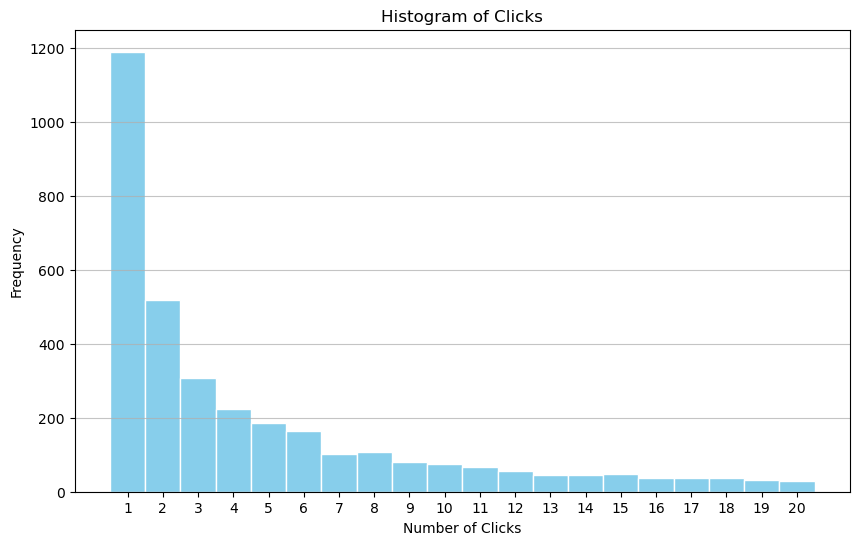

/var/folders/hp/ckxj948944zcmlndr0p65bwh0000gn/T/ipykernel_3594/714673612.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clicks_per_bin = df_train.groupby('Impression_Bins')['Clicks'].mean()


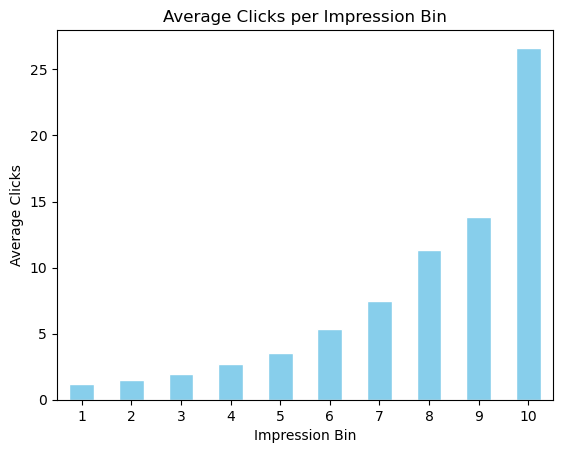

/var/folders/hp/ckxj948944zcmlndr0p65bwh0000gn/T/ipykernel_3594/714673612.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clicks_per_avg_cpc_bin = df_train.groupby('Avg_CPC_Bins')['Clicks'].mean()


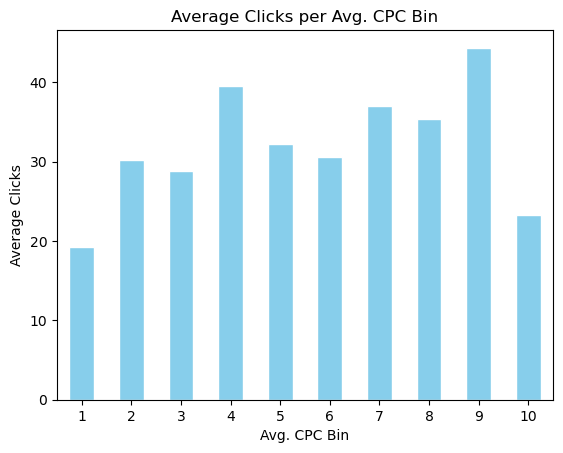

/var/folders/hp/ckxj948944zcmlndr0p65bwh0000gn/T/ipykernel_3594/714673612.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clicks_per_search_bid_bin = df_train.groupby('Search_Bid_Bins')['Clicks'].mean()


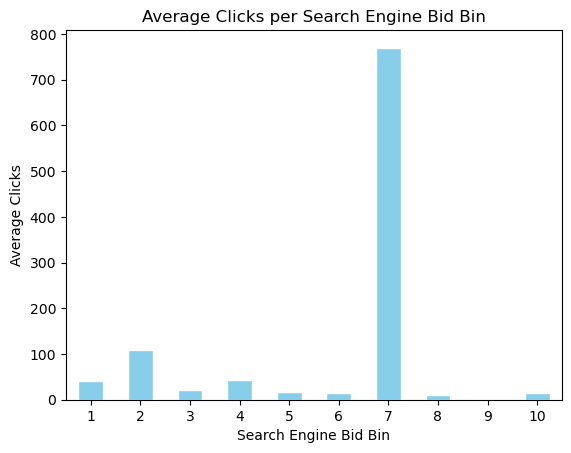

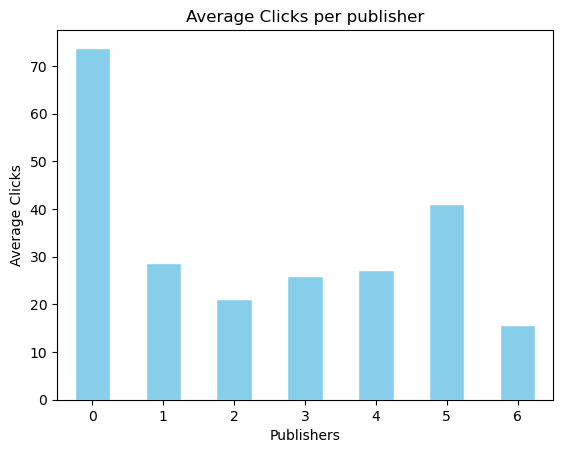

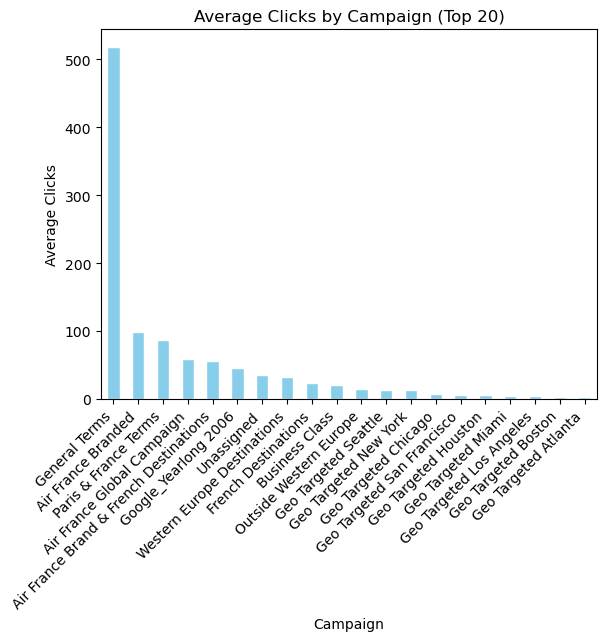

In [48]:
###Creating a plot to see the distribution of the Clicks column

#Filtering to only see the data in the range of 1 - 20 clicks
filtered_clicks = df_train['Clicks'][(df_train['Clicks'] >= 1) & (df_train['Clicks'] <= 20)]

#Plotting the histogram for clicks in the range of 1 - 20
plt.figure(figsize = (10, 6))
plt.hist(filtered_clicks, bins = 20, range = (1,21), color = 'skyblue', edgecolor = 'white', align = 'left')

#Adding title, label, ticks and a grid to the plot
plt.title('Histogram of Clicks')
plt.xlabel('Number of Clicks')
plt.ylabel('Frequency')
plt.xticks(range(1, 21))  
plt.grid(axis = 'y', alpha = 0.75)

#Showing the plot
plt.show()

###Creating a plot to see the avg Clicks per Impressions bin

#Creating bins to divide the values in the impressions column by percentile 
bins = df_train['Impressions'].quantile([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]).tolist()
df_train['Impression_Bins'] = pd.cut(df_train['Impressions'], bins, labels = range(1,11))

#Calculating the avg Clicks per bin
clicks_per_bin = df_train.groupby('Impression_Bins')['Clicks'].mean()

#Creating the bar plot
clicks_per_bin.plot(kind = 'bar', color = 'skyblue', edgecolor = 'white')

#Adding title, label and ticks to the plot
plt.title('Average Clicks per Impression Bin')
plt.xlabel('Impression Bin')
plt.ylabel('Average Clicks')
plt.xticks(rotation = 0)  

#Showing the plot
plt.show()

###Creating a plot to see the avg Clicks per 'Avg. Cost per Click' bin

#Creating bins to divide the values in the 'Avg. Cost per Click' column by percentile 
bins_2 = df_train['Avg. Cost per Click'].quantile([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]).tolist()
df_train['Avg_CPC_Bins'] = pd.cut(df_train['Avg. Cost per Click'], bins_2, labels = range(1, 11))

#Calculating the avg Clicks per bin
clicks_per_avg_cpc_bin = df_train.groupby('Avg_CPC_Bins')['Clicks'].mean()

#Creating the bar plot
clicks_per_avg_cpc_bin.plot(kind = 'bar', color = 'skyblue', edgecolor = 'white')

#Adding title, label and ticks to the plot
plt.title('Average Clicks per Avg. CPC Bin')
plt.xlabel('Avg. CPC Bin')
plt.ylabel('Average Clicks')
plt.xticks(rotation = 0)

#Showing the plot
plt.show()

###Creating a plot to see the avg Clicks per 'Search Engine Bid' bin

#Creating bins to divide the values in the 'Search Engine Bid' column
bins_3 = np.linspace(df_train['Search Engine Bid'].min(), df_train['Search Engine Bid'].max(), 11)
df_train['Search_Bid_Bins'] = pd.cut(df_train['Search Engine Bid'], bins_3, labels = range(1, 11))

#Calculating the avg Clicks per bin
clicks_per_search_bid_bin = df_train.groupby('Search_Bid_Bins')['Clicks'].mean()

#Creating the bar plot
clicks_per_search_bid_bin.plot(kind = 'bar', color = 'skyblue', edgecolor = 'white')

#Adding title, label and ticks to the plot
plt.title('Average Clicks per Search Engine Bid Bin')
plt.xlabel('Search Engine Bid Bin')
plt.ylabel('Average Clicks')
plt.xticks(rotation = 0)

#Showing the plot
plt.show()

###Creating a plot to see the avg Clicks per 'Publisher Name' 

#Calculating the avg Clicks per publisher
clicks_per_publisher = df_train.groupby('Publisher_encoded')['Clicks'].mean()

#Creating the bar plot
clicks_per_publisher.plot(kind = 'bar', color = 'skyblue', edgecolor = 'white')

#Adding title, label and ticks to the plot
plt.title('Average Clicks per publisher')
plt.xlabel('Publishers')
plt.ylabel('Average Clicks')
plt.xticks(rotation = 0)  

#Showing the plot
plt.show()

###Creating a plot to see the avg Clicks per 'Publisher Name'

#Calculating the avg Clicks per Campaign
average_clicks_by_campaign = df_train.groupby('Campaign')['Clicks'].mean()

#Sorting the results
sorted_avg_clicks_by_campaign = average_clicks_by_campaign.sort_values(ascending=False)

#Limiting the plot to the top 20 campaigns
top_campaigns = sorted_avg_clicks_by_campaign.head(20)

#Creating the bar plot 
top_campaigns.plot(kind = 'bar', color = 'skyblue', edgecolor = 'white')

#Adding title, label and ticks to the plot
plt.title('Average Clicks by Campaign (Top 20)')
plt.xlabel('Campaign')
plt.ylabel('Average Clicks')
plt.xticks(rotation = 45, ha = "right")  

#Showing the plot
plt.show()

Explanation of Data Visualizations: 

1. Histogram of Clicks:
This Histogram helped us get an idea of the results are distributed in the train data. Seeing that the great majority of the references fell under 5 Clicks served as a benchmark for us to create the features that would end up going into the final model. Knowing that only few references had a large number of clicks directed our work towards better identifying those references with low number of clicks. Because the goal of the model was to achieve the lowest RMSE possible, taking this approach proved to be very effective. In addition not focusing so much on nailing the references with many Clicks ended up working in our favor when applying the model to the Kaggle data. 

2. Average Clicks per Impression Bin:
This bar plot was essential for us when engineering features. At the beginning we weren't sure on what features would be good to incorporate to the model. Because impressions seemed to be all over the place in the data we weren't sure if this feature would be useful when modeling. When plotting the Impression bins against the Avg Clicks per Bin we noticed that the more impressions a reference had, the higher the amount of clicks. This finding was critical for us when developing the features that would form our final model.

3. Average Clicks per Publisher:
At the beginning of our work we really struggle to decide which features would better our model. From our analysis in R we already knew that not all publishers were made equal. But, being able to see that this also reflected in the train data was a big step for us. Google was the publisher with the most clicks, more specifically Google - Global. Being able to add this rational into the model definitely improved our final model.

<br><h3>Missing Value Analysis and Imputation</h3>

In [49]:
###Missing value analysis

#Checking for missing values
missing_summary = df_train.isnull().sum()

###Analysing which publisher names had missing values (We thought maybe only google had some)

#slicing the rows with missing values
rows_with_missing_values = df_train[df_train['Match Type'].isnull()]

#Checking which Publishers have missing values 
rows_with_missing_values = rows_with_missing_values['Publisher Name'].value_counts()

###Doing analysis on the Match Type column to figure out how best to imputate the missing values

#Separating the rows that have Publisher Name = to Google US
google_us = df_train[df_train['Publisher Name'] == 'Google - US']

#Seeing the different values inside the Match Type column and their count
google_us_values = google_us['Match Type'].value_counts()

#Separating the rows that have Publisher Name = to Google Global
google_global = df_train[df_train['Publisher Name'] == 'Google - Global']

#Seeing the different values inside the Match Type column and their count
google_global_values = google_global['Match Type'].value_counts()

#Printing results
print(f"""
Missing Values in each column:\n {missing_summary}

Rows with missing values:\n {rows_with_missing_values}

Google US value count:\n {google_us_values} 
        
Google Global value count:\n {google_global_values}""")




Missing Values in each column:
 Publisher Name            0
Keyword                   0
Match Type               44
Campaign                  0
Keyword Group             0
Category                  0
Bid Strategy           1193
Status                    0
Search Engine Bid         0
Impressions             987
Avg. Pos.                 0
Avg. Cost per Click       0
Clicks                   69
set                       0
Publisher_encoded         0
Impression_Bins        1113
Avg_CPC_Bins              1
Search_Bid_Bins         222
dtype: int64

Rows with missing values:
 Publisher Name
Google - US        37
Google - Global     7
Name: count, dtype: int64

Google US value count:
 Match Type
Broad    1977
Exact      19
Name: count, dtype: int64 
        
Google Global value count:
 Match Type
Broad    372
Exact      2
Name: count, dtype: int64


In [50]:
###Imputating missing values and replacing special characters

#Chaning missing values in the Bid Strategy Column into no strategy
df_full['Bid Strategy'].fillna('No Strategy', inplace = True)

#Changing missing values in the Match Type column into broad
df_full['Match Type'].fillna('Broad', inplace = True)

#Checking for any other missing values in the data
missing_sum = df_full.isnull().sum()

print(f"Misssing values:\n {missing_sum}")

###Deleting special characters from the data 

#Deleting special characters in the Search Engine Bid column
df_full['Search Engine Bid'] = df_full['Search Engine Bid'].astype(str).replace('\$','', regex = True)

#Deleting special characters in the Avg. Cost per Click column
df_full['Avg. Cost per Click'] = df_full['Avg. Cost per Click'].astype(str).replace('\$','', regex = True)

#Deleting special characters in the Impressions column
df_full['Impressions'] = df_full['Impressions'].astype(str).replace('\,','', regex = True)

#Deleting special characters in the Clicks column
df_full['Clicks'] = df_full['Clicks'].astype(str).replace('\,','', regex = True)

Misssing values:
 Publisher Name           0
Keyword                  0
Match Type               0
Campaign                 0
Keyword Group            0
Category                 0
Bid Strategy             0
Status                   0
Search Engine Bid        0
Impressions              0
Avg. Pos.                0
Avg. Cost per Click      0
Clicks                 100
set                      0
dtype: int64


<br><h3>Transformations</h3>

In [51]:
###Transforming categorical features into numbers

#Encoding the Match Type column
df_full['MatchType_encoded'] = le.fit_transform(df_full['Match Type']) 

#Encoding the Publisher Name column
df_full['Publisher_encoded'] = le.fit_transform(df_full['Publisher Name'])

#Encoding the Campaign column
df_full['Campaign_encoded'] = le.fit_transform(df_full['Campaign']) 

#Changing 'No Strategy' values in the Bid Strategy column to 0
df_full['Bid Strategy'][df_full['Bid Strategy'] == 'No Strategy'] = 0

#Eliminating all non numerical data from the Bid Strategy column
df_full['Bid Strategy'] = df_full['Bid Strategy'].astype(str).replace('[^\d]+', '', regex=True)

#Changing the Clicks column type first to numeric and then to interger
df_full['Clicks'] = pd.to_numeric(df_full['Clicks'], errors = 'coerce')
df_full['Clicks'] = df_full['Clicks'].astype('Int64')

#Changing the Avg. Pos. column type first to numeric and then to interger
df_full['Avg. Pos.'] = pd.to_numeric(df_full['Avg. Pos.'], errors = 'coerce')
df_full['Avg. Pos.'] = df_full['Avg. Pos.'].astype('Float64')

#Changing the Avg. Cost per Click column type first to numeric and then to interger
df_full['Avg. Cost per Click'] = pd.to_numeric(df_full['Avg. Cost per Click'], errors = 'coerce')
df_full['Avg. Cost per Click'] = df_full['Avg. Cost per Click'].astype('Float64')

#Creating the log_Clicks column as the log of Clicks
df_full['log_Clicks'] = np.log1p(df_full['Clicks'])

df_full['Impressions'] = df_full['Impressions'].astype(int)
df_full['Search Engine Bid'] = df_full['Search Engine Bid'].astype(float)

/var/folders/hp/ckxj948944zcmlndr0p65bwh0000gn/T/ipykernel_3594/1424162503.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['Bid Strategy'][df_full['Bid Strategy'] == 'No Strategy'] = 0


<br><h3>Feature Engineering</h3>

In [52]:
###Grouping the bid strategies into 4 categories:

#Defining the conditions for each category
condition_list = [
                  df_full['Bid Strategy'] == '0',  # 0
                  df_full['Bid Strategy'].isin(['12', '13', '14']),  # 3
                  df_full['Bid Strategy'].isin(['25', '36']),  # 2
                  df_full['Bid Strategy'] == '510'  # 1
                 ]

#Defining the labels for each category
label_list = [0, 3, 2, 1]

#Creating a new column called bid_strat_groups to divide the Impressions column into 4 categories
df_full['bid_strat_groups'] = np.select(condition_list, label_list, default = np.nan)

###Adding a feature to divide the values in the Impressions column by percentiles

#Changing the impressions column type to interger
df_full['Impressions'] = df_full['Impressions'].astype(int)

#Creating bins to divide the values in the impressions column by percentile 
bins = df_full['Impressions'].quantile([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]).tolist()

#Creating a list of labels to assign to each bin
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10] 

#Creating a new column with the Impressions data divided by bins
df_full['impressions_groups'] = pd.cut(df_full['Impressions'], bins = bins, labels = labels, include_lowest = True)

###Adding a feature to divide the values in the Avg. Pos. column by percentiles

#Creating bins to divide the values in the Avg. Pos. column by percentile 
bins_1 = df_full['Avg. Pos.'].quantile([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]).tolist()

#Creating a list of labels to assign to each bin
labels_1 = [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10] 

#Creating a new column with the Avg. Pos. data divided by bins
df_full['avg_pos_groups'] = pd.cut(df_full['Avg. Pos.'], bins = bins_1, labels = labels_1, include_lowest = True)

###Adding a feature to divide the values in the Avg. Cost per Click column by percentiles

#Changing the Avg. Cost per Click column type to float
df_full['Avg. Cost per Click'] = df_full['Avg. Cost per Click'].astype(float)

#Creating bins to divide the values in the Avg. Pos. column by percentile 
bins_2 = df_full['Avg. Cost per Click'].quantile([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]).tolist()

#Creating a list of labels to assign to each bin
labels_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10] 

#Creating a new column with the Avg. Pos. data divided by bins
df_full['avg_cpc_groups'] = pd.cut(df_full['Avg. Cost per Click'], bins = bins_2, labels = labels_2, include_lowest = True)

###Adding a feature to calculate the number of words in the Keyword column

#Creating a feature that counts the number of words in the Keyword column
df_full['Keyword Length'] = df_full['Keyword'].apply(lambda x: len(x.split()))

###Changing the type of columns to numeric and then to interger

#Creating a list of the columns that will be changed
column_list = ['impressions_groups','avg_cpc_groups', 'avg_pos_groups']

#For loop to convert the type of the columns
for column in column_list:
    #Converting the column to numeric
    df_full[column] = pd.to_numeric(df_full[column], errors = 'coerce')
    
    #Converting the column to interger
    df_full[column] = df_full[column].astype('int64')

    
###Last attempt at glory    

#Creating features  that determine whether the publisher is google, msn, overture or yahoo
df_full['Is_Google'] = df_full['Publisher Name'].str.contains('Google', case=False).astype(int)
df_full['Is_Overture'] = df_full['Publisher Name'].str.contains('Overture', case=False).astype(int)
df_full['Is_Yahoo'] = df_full['Publisher Name'].str.contains('Yahoo', case=False).astype(int)
df_full['Is_MSN'] = df_full['Publisher Name'].str.contains('MSN', case=False).astype(int)


#Creating features that determine whether the publisher is US or Global
df_full['Is_US'] = df_full['Publisher Name'].str.contains('US', case=False).astype(int)
df_full['Is_Global'] = df_full['Publisher Name'].str.contains('Global', case=False).astype(int)


Critical things to know from exploratory data analysis, data preprocessing, and feature engineering:

Exploratory data analysis showed that most features would have to be transformed for them to be utilized in the model. Many where categorical features that had to be encoded, and others where in types that had to be changed into numerical data. The most important original features were determined to be impressions, Publisher Name, Campaign and Search Engine Bid. From these features most of the other ones where engineered. We decided not to focus too much on the Keyword feature given that these keywords might be very different from the ones in the Kaggle data. Therefore, we only did a feature that calculated the number of words in the Keyword, given that this impacted the amount of Clicks and added value to the model. Regarding data processing, the missing values were easy to impute given that most could be imputed using the same value. Having to transform the type of the data and encoding categorical data was a recurring theme. The trickiest feature was Bid Strategy, where we had to first eliminate non numerical characters and then group the results in a ranking system. Most engineered features where derived groups from original features such as Impressions groups and avg_cpc_groups (cpc = cost per click). Finally, using log_Clicks proved to have better results than using just Clicks.

In a last attempt at glory, we introduced 5 new features to categorize the publisher names in a better way. We dropped all the other features we created and uploaded the model in this manner, getting a better score. This was done at the very last moment before the submission, so we decided to leave or previous work, to showcase the big chunk of our work. Even though less, was more. Lesson learned.


<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Data Partitioning</h2><br>

<br><h3>Separating the Kaggle Data</h3><br>

In [31]:
## parsing out testing data (needed for later) ##

# dataset for kaggle
kaggle_data = df_full[ df_full['set'] == 'Kaggle' ].copy()


# dataset for model building
df = df_full[ df_full['set'] == 'Not Kaggle' ].copy()
df = df[df['Clicks'] < 1000000]

# dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

<br><h3>Train-Test Split</h3><br>

In [33]:
#Stablishing x features for the model
x_features = ['MatchType_encoded', 'Publisher_encoded', 'Campaign_encoded', 'bid_strat_groups', 'impressions_groups', 'avg_pos_groups', 'avg_cpc_groups', 'Keyword Length']

In [34]:
#This were the features used in our last try
x_features = ['Impressions', 'Search Engine Bid', 'Is_Google',
       'Is_Overture', 'Is_Yahoo', 'Is_MSN', 'Is_US', 'Is_Global']

In [35]:
#Stablishing y variable for the model
y_variable = 'Clicks' 

<br>

In [ ]:
#Prepping data for train-test split
y_data = df[y_variable]


#Removing non-numeric columns and missing values
x_data = df[x_features].copy().select_dtypes(include=[int, float]).dropna(axis = 1)


#Storing remaining x_features after the step above
x_features = list(x_data.columns)


#Train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.2,
                                                    random_state = 7 )


#Results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df.shape[0]}
Features  (Columns): {df.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")

In [43]:
#Best params used in the final model:

random_search.best_params_ =  {'min_samples_split': 6, 'min_samples_leaf': 9, 'max_depth': 70, 'criterion': 'squared_error'}

In [37]:
#Hyperparameter Tuning for Tree Model

#Stablishing hyperparameter ranges
param_grid = {
    'criterion' : ['squared_error', 'friedman_mse'],
    'max_depth': [5,10, 20, 30, 35, 40, 42, 43, 45, 50, 60, 70, 80, 90, 100], 
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(2, 10)
        }
#Using RandomizedSearchCV to pick the best hyperparameters
random_search = RandomizedSearchCV(estimator             = sklearn.tree.DecisionTreeRegressor(), 
                                   param_distributions   = param_grid, 
                                   cv                    = 3,          
                                   n_iter                = 500,       
                                   random_state          = 98)


#Fitting the search to the data
random_search.fit(x_train, y_train)


print(f"""Best Parameters: {random_search.best_params_}\n""")

Best Parameters: {'min_samples_split': 6, 'min_samples_leaf': 9, 'max_depth': 70, 'criterion': 'squared_error'}



In [ ]:
#Hyperparameter Tuning for NeuralNet

# Data scaling
#scaler = StandardScaler()
#x_train_scaled = scaler.fit_transform(x_train)
#x_test_scaled = scaler.transform(x_test)

 #Stablishing hyperparameter ranges
param_grid = {
        'hidden_layer_sizes': np.arange(10,40,1),
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'alpha': np.arange(0.0001, 1, 0.05),
        'solver': ['sgd', 'adam'],
        'learning_rate': ['constant', 'adaptive','nvscaling']
    }
    
# Using RandomizedSearchCV to pick the best hyperparameters
random_search = RandomizedSearchCV(estimator=MLPRegressor(), 
                                   param_distributions=param_grid, 
                                   n_iter=500, 
                                   cv   =3,
                                   random_state=98)

#Fitting the search to the data
random_search.fit(x_train, y_train)


print(f"""Best Parameters: {random_search.best_params_}\n""")

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Candidate Modeling</h2><br>

In [44]:
#This is the model used for the final submission

#Naming the model
model_name = 'TREE' 

#Stablishing the model
model = sklearn.tree.DecisionTreeRegressor(random_state = 98, **random_search.best_params_)

In [ ]:
#Naming the model
model_name = 'ElasticNet'

#Stablishing the model
model = SGDRegressor(random_state = 98, **random_search.best_params_)

In [ ]:
#Naming the model
model_name = 'NeuralNet'

#Stablishing the model
model = MLPRegressor(random_state = 98, **random_search.best_params_ )

<br>

In [39]:
# Fitting the model to the training data
model_fit = model.fit(x_train, y_train)

# Predicting on both training and new (test) data
model_pred_train = model.predict(x_train)  # Predictions for the training set
model_pred_test = model.predict(x_test)    # Predictions for the test set

# Scoring the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score = model.score(x_test, y_test).round(4)
model_gap = abs(model_train_score - model_test_score).round(4)

# Calculating MSE for both training and testing predictions
mse_train = mean_squared_error(y_train, model_pred_train)
mse_test = mean_squared_error(y_test, model_pred_test)

# Calculate the RMSE for both training and testing predictions
rmse_train = np.sqrt(mse_train).round(4)
rmse_test = np.sqrt(mse_test).round(4)

# Optionally, print out the results
print(f"Train Score: {model_train_score}")
print(f"Test Score: {model_test_score}")
print(f"Train-Test Gap: {model_gap}")
print(f"Train RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")

Train Score: 0.4758
Test Score: -0.9532
Train-Test Gap: 1.429
Train RMSE: 814.4112
Test RMSE: 673.3668


Candidate model development and final model selection:

As a team we tried using KNN and DecisionTree given the familiarity we had with these models. Apart from that we tried to incorporate a Neural Network model, but the results we obtained ended up being worse than using DecisionTree or KNN. This was do to bad or lack of scaling, and because the features we engineered were not optimal to describe the data. After a lot of work we realized that the manner in which we grouped and categorized features such as Impressions and Publisher name, made the model worse instead of improving it. We noticed this when just using 'Impressions' and 'Search Engine Bid' gave us better RMSE scores. Because of this we decided to stick with DecisionTree, given that it showed the lower RMSE scores and the lowest gap between test and train. 

<br>
<h3>Residual Analysis</h3><br>

In [ ]:
###Residual Analysis

#y_test = np.expm1(y_test).round(0)
#model_pred_test = np.expm1(model_pred_test).round(0)

#Organizing residuals
model_residuals = {"True"            : y_test,
                   "Predicted"       : model_pred_test
                  }


#Converting residuals into df
model_resid_df = pd.DataFrame(data = model_residuals)


#Checking results
model_resid_df.head(n = 100)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part IV: Preparing Submission File for Kaggle</h2><br>
The code below will store the predicted values for each of the models above.

In [40]:
#x-data
x_data_kaggle = kaggle_data[x_features].copy()


#y-data
y_data_kaggle = kaggle_data[y_variable]

#Activate if scaling data
#x_data_kaggle = scaler.fit_transform(x_data_kaggle)


#Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

#Activate if using log_rentals
#kaggle_predictions = np.expm1(kaggle_predictions).round(0)

<br>
<h3>Creating the Kaggle File</h3><br>

In [41]:
###Kaggle Submission File

#Organizing predictions
model_predictions = {"Clicks" : kaggle_predictions}


#Converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test.index)

<br>

In [42]:
#Naming the cvs file with the Kaggle results
model_pred_df.to_csv(path_or_buf = "./model_output/try16.csv",
                     index       = True,
                     index_label = 'entry_id')

<br>

<br>